In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Monte Carlo

Monte Carlo simulation rely on repeated random sampling from known or assumed
probability distributions. They are particularly useful for modelling cases with
significant uncertainty in inputs and complex systems where analytical solutions
are difficult or impossible to obtain.

Example

We are throwing darts into a square which sizes of lenght 2. The dart will fall
in the square, necessarily, but its exactly position is random. There is a circle
of radius 1 inside. WHats is the probability that the darts fall inside of the 
circle?

We now that the probability oof throwing in the circle is proportional to the 
area of the circle ($\pi/4$). BUt let's solve this using monte carlo.

<img src="images/monte_carlo_darts.png" alt="Center" width="450"/>



In [2]:

n = 10**6    # number of simulations
inside_circle = 0   # how many darts fell inside the circle (we care about circ/n)

for i in range(n):
    x = np.random.uniform(-1, 1) # horizontal point
    y = np.random.uniform(-1, 1) # vertical point

    # Does the point fall inside the circle?

    if x**2 + y**2 <=1:
        inside_circle += +1

print(f"inside_circle/total: {inside_circle/n}")

inside_circle/total: 0.786072


# Markov Chains

Markov chain is a class of  mathematical models that represents a system that  
transitions from one state to another within a finite or countable number of 
possible states. It is a stochastic process characterized by the 
**Markov property**, which states that the future state depends only on the 
current state and not on the sequence of events that preceded it.

Formally,

$$
P(X_{t+1} = x | X_n = x_t, X_{t-1} = x_{t-1}, \dots, X_0 = x_0) = P(X_{t+1} = x | X_t = x_t)
$$

* State Space: The set of all possible states.

* Initial State Distribution: Probabilities of starting states.

* Transition Probabilities: Probabilities of moving from one state to another.

* Transition Matrix: A square matrix where each element  $P_{ij}$ represents the 
transition probability from state $i$ to state  $j$.

* Stationary Distribution (steady state):  probability distribution over states that 
remains unchanged as the system evolves.


### Example: Web Page Navigation

Suppose we’re modeling a user’s navigation between web pages on a website. The 
pages are:1-Home, 2-About, 3-Products, 4-Contact. The end goal of this exercise 
is to simulate and analyze the long-term behavior of a user’s navigation patterns 
to answer questions such as:
1. What is the likelihood that a user will visit each page over time?
2. How does the user’s navigation evolve over multiple steps?
3. What is the expected frequency of visits to each page? Which one is the most
popular?
4. Does the user tend to get “stuck” on certain pages (absorbing states)?


**Transition Matrix**
| From \ To | Home | About | Products | Contact |
|-----------|------|-------|----------|---------|
| Home      | 0.1  | 0.4   | 0.4      | 0.1     |
| About     | 0.2  | 0.1   | 0.6      | 0.1     |
| Products  | 0.3  | 0.2   | 0.4      | 0.1     |
| Contact   | 0.5  | 0.2   | 0.2      | 0.1     |

Moreover, we are assuming that all user starts from the home page (this defines 
the initial state probabilities). 

In [3]:
# Setting states and transition matrix

states = ['Home', 'About', 'Products', 'Contact']

transition_matrix = np.array([
    [0.1, 0.4, 0.4, 0.1],  # From Home
    [0.2, 0.1, 0.6, 0.1],  # From About
    [0.3, 0.2, 0.4, 0.1],  # From Products
    [0.5, 0.2, 0.2, 0.1],  # From Contact
])

In [4]:
def markov_chain(transition_matrix, states, initial_state=0, num_steps=100):
    """"    
    Returns:
    -------
    state_sequence : list
        Sequence of states visited during the simulation.
    state_indices : list
        Sequence of state indices corresponding to the states.
    """

    # Initialization
    current_state = initial_state
    state_sequence= [states[current_state]]
    state_indices = [current_state]

    for _ in range(num_steps):
        # Get transition probabilities for current state
        transition_probs = transition_matrix[current_state] 

        # Choose the next state based on transition probabilities
        next_state = np.random.choice(
            range(len(states)),  # Choose the index (integer)
            p = transition_probs )
        
        # Update current state
        current_state = next_state

        #Record the state
        state_sequence.append(states[current_state])
        state_indices.append(current_state)

    return state_sequence, state_indices

In [5]:

state_sequence, state_indices = markov_chain(
    transition_matrix, states
)

# Print the sequence of visited states
print("Sequence of Visited States:")
print(" -> ".join(state_sequence))

Sequence of Visited States:
Home -> About -> Products -> About -> Products -> Products -> Home -> Products -> Contact -> Products -> About -> Products -> About -> Home -> Products -> Home -> About -> Home -> Products -> Products -> Products -> About -> Home -> About -> Products -> Products -> About -> Products -> Products -> About -> About -> Home -> About -> Products -> Contact -> Contact -> Home -> Contact -> Products -> Products -> Home -> Products -> About -> Products -> Products -> Products -> About -> Products -> Home -> About -> Products -> Products -> Products -> About -> Products -> Products -> Products -> Products -> Products -> Products -> Products -> Home -> Products -> Products -> About -> Products -> Contact -> Products -> Products -> Products -> Products -> Products -> Home -> About -> Products -> Products -> About -> Products -> Home -> Products -> Products -> Products -> Products -> Home -> About -> Products -> Products -> Home -> Products -> Products -> About -> Produ

In [6]:
# Count the number of visits to each state
visit_counts = pd.Series(state_sequence).value_counts().reindex(states).fillna(0)

# Calculate the visit proportions
visit_proportions = visit_counts / len(state_sequence)

# Display the results
print("\nVisit Counts:")
print(visit_counts)

print("\nVisit Proportions:")
print(visit_proportions)


Visit Counts:
Home        17
About       21
Products    57
Contact      6
Name: count, dtype: int64

Visit Proportions:
Home        0.168317
About       0.207921
Products    0.564356
Contact     0.059406
Name: count, dtype: float64


# MCMC: Markov Chain Monte Carlo


MCMC sampling is an algorithm for systematic random sampling from high-dimensional
probability distributions. Unlike Monte Carlo sampling methods that are able to 
draw independent samples from the distriution, MCMC draw samples where the next
sample is dependent on the existing sampling (that is, the Markov property holds).

* Bottomline: we are adding a Markov properti to a Monte Carlo Sampling. This 
implies that the samples are not independent: they depend of the last state.

Therefore, this algorithm generates a **Markov Chain** that has the desired 
distributions as its **stationary distribution**. 

* The goal of MCMC is to generate samples from a complex target distribution  
    $P(x)$  by constructing a Markov chain that converges to this distribution.


### Algorithm:

1. Start with a initial value $x_0$
2. for $t = 1,2,...N$:
    - Draw candidate $x'$ from a proposed distribution $q$
    
    - Calculate the acceptance ratio $r$ and acceptance probability $A$. If
the distribution is normal:
             $$ r(x', x) = \frac{P(x')}{P(x)} $$
             $$ \alpha = \min(1, r )$$
    - Accept or reject $x'$    

In [7]:
from scipy.stats import norm

def metropolis_hastings(taget_density, proposal_sampler, 
                        initial_state=0, num_samples=10000):
    """
    Metropolis-Hastings algorithm for sampling from a target distribution.
    
    Parameters:
    ----------
    target_density : function
        The target probability density function P(x) we want to sample from.
    proposal_sampler : function
        Function to sample a candidate point given the current state.
    initial_state : float
        Starting point of the Markov chain.
    num_samples : int
        Number of samples to generate.
    
    Returns:
    -------
    samples : numpy.ndarray
        Generated samples from the target distribution.

    """
    samples = []
    current_state = initial_state

    for _ in range(num_samples):
        # Sample from the proposal distribution (normal distribution centered 
        # at current state)
        proposed_state = proposal_sampler(current_state)
        
        # Calculate the acceptance probability
        acceptance_ratio = target_density(proposed_state)/\
                           target_density(current_state)
        
        acceptance_prob = min(1, acceptance_ratio)

        # Accept or reject x'
        if np.random.uniform(0,1) < acceptance_prob:
            current_state = proposed_state
        
    
        samples.append(current_state)

    return  samples

# Define the target density function (standard normal distribution)
def target_density(x):
    return norm.pdf(x, loc=0, scale=1)

# Define the proposal sampler (normal distribution centered at current state)
def proposal_sampler(x_current):
    return np.random.normal(loc=x_current, scale=1)





    

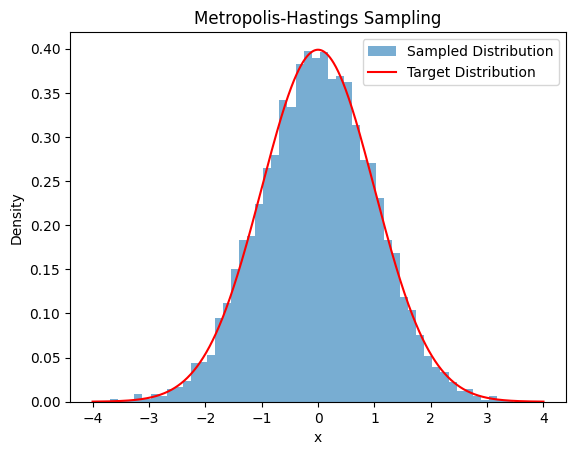

In [8]:
samples = metropolis_hastings(target_density,proposal_sampler)

# Plot the histogram of samples
plt.hist(samples, bins=50, density=True, alpha=0.6, label='Sampled Distribution')

# Plot the target distribution
x = np.linspace(-4, 4, 1000)
plt.plot(x, norm.pdf(x), 'r', label='Target Distribution')

plt.title("Metropolis-Hastings Sampling")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()
